# Linear elasticity

This demo shows how to define a linear problem, apply boundary conditions, solve for the solution and output to a results file.

$\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\rebeps}{\boldsymbol{\varepsilon}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\bT}{\boldsymbol{T}}
\newcommand{\dOm}{\,\text{d}\Omega}
\newcommand{\dS}{\,\text{d}S}
\newcommand{\Neumann}{{\partial \Omega_\text{N}}}
\newcommand{\Dirichlet}{{\partial \Omega_\text{D}}}$

## Variational formulation

The variational formulation of a linear elastic problem is given by:
> Find $\bu \in V$ such that:
> \begin{equation*}
\int_\Omega \bsig(\bu):\nabla^\text{s} \bv \dOm = \int_\Omega \boldsymbol{f}\cdot\bv \dOm + \int_\Neumann \bT\cdot\bv \dS \quad \forall \bv \in V_0
\end{equation*}

where $\bu$ is the unknown displacement (the *trial* function) living in the space of admissible displacements $V$ such that $\bu=\bu_0$ on the Dirichlet boundary $\Dirichlet$. $\boldsymbol{f}$ and $\bT$ are respectively body and surface traction forces. $\sigma(\bu)$ is the Cauchy stress field which depends on the displacement $\bu$. Finally, $\bv$ denotes *test* functions living in the space of admissible perturbations $V_0$ i.e. such that $\bv=0$ on $\Dirichlet$.

The above variational formulation represents the weak form of equilibrium and must be supplemented by a constitutive relation. In the linear elastic case, we have $\bsig(\bu) = \mathbb{C}:\nabla^s \bu$ where $\mathbb{C}$ is the stiffness tensor

> Find $\bu \in V$ such that:
> \begin{equation*}
\int_\Omega \nabla^\text{s}\bu:\mathbb{C}:\nabla^\text{s} \bv \dOm = \int_\Omega \boldsymbol{f}\cdot\bv \dOm + \int_\Neumann \bT\cdot\bv \dS \quad \forall \bv \in V_0
\end{equation*}

The left-hand side is a *bilinear form* of $\bu$ and $\bv$ whereas the right-hand side is a *linear form*. The above equality is generally written as $a(\bu,\bv) = L(\bv)\quad \forall \bv \in V_0$.

FEniCS makes use of the **UFL** librairy ([Unified Form Language](https://github.com/FEniCS/ufl)] to handle symbolic expressions involved in the above formulation. UFL also provide the `TestFunction` and `TrialFunction` objects appearing as arguments of linear or bilinear forms. The power of FEniCS is precisely to easily define such forms and, once a finite element basis has been chosen, automatically generate code to compute the corresponding global stiffness matrix ($\mathbf{K}$ associated to the bilinear form $a$) and vector of nodal forces ($\mathbf{f}$ for the linear functional $L$).


* **DOLFINx**: The `dolfinx` package is the Python interface to the computational environment of FEniCSx. It provides all the necessary tools to load meshes, handle data structures and functions related to finite-elements (global FE function spaces and associated functions, assembling procedures, boundary conditions, solvers, etc.).

* other packages may include `mpi4py` for MPI parallel communication, `petsc4py` for interaction with PETSc objects, `ffcx` for Just-In-Time compilation of forms, etc.

### Problem definition

We will model a 2D rectangular beam of dimensions $10\times 1$ which we will mesh with quadrangles. We first start by loading the relevant packages and functions. The `dolfinx.mesh` module provides a customary function for meshing a rectangular domain. For more complex cases, we can import meshes generated by external tools such as GMSH for instance.

In [10]:
import numpy as np
from ufl import sym, grad, Identity, tr, inner, Measure, TestFunction, TrialFunction

from mpi4py import MPI

from dolfinx import fem, io
import dolfinx.fem.petsc
from dolfinx.mesh import create_rectangle, CellType

length, height = 10, 1.0
Nx, Ny = 50, 5
domain = create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([length, height])],
    [Nx, Ny],
    cell_type=CellType.quadrilateral,
)

dim = domain.topology.dim
print(f"Mesh topology dimension d={dim}.")

Mesh topology dimension d=2.


To solve the problem we use Lagrange finite elements of order 2. To do so, the associated function space is declared.

In [11]:
degree = 2
shape = (dim,)  # this means we want a vector field of size `dim`
V = fem.functionspace(domain, ("Lagrange", degree, shape))

u_sol = fem.Function(V, name="Displacement")

By using UFL, the required expression can be defined easily and concisely.

In [12]:
E = fem.Constant(domain, 210e3)
nu = fem.Constant(domain, 0.3)

lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2 / (1 + nu)


def epsilon(v):
    return sym(grad(v))


def sigma(v):
    return lmbda * tr(epsilon(v)) * Identity(dim) + 2 * mu * epsilon(v)

We can check that such objects are indeed abstract UFL expressions (they are represented as graphs internally).

In [13]:
print("mu (UFL):\n", mu)
print("epsilon (UFL):\n", epsilon(u_sol))
print("sigma (UFL):\n", sigma(u_sol))

mu (UFL):
 c_3 / 2 / (1 + c_4)
epsilon (UFL):
 sym(grad(Displacement))
sigma (UFL):
 ({ A | A_{i_{34}, i_{35}} = (sym(grad(Displacement)))[i_{34}, i_{35}] * 2 * c_3 / 2 / (1 + c_4) }) + ({ A | A_{i_{32}, i_{33}} = I[i_{32}, i_{33}] * c_3 * c_4 / (1 + c_4) / (1 + -1 * 2 * c_4) * (tr(sym(grad(Displacement)))) })


We now define the corresponding linear and bilinear forms. Below, `dx` is the volume integration measure on the whole domain.

In [14]:
u = TrialFunction(V)
v = TestFunction(V)

rho = 2e-3
g = 9.81
f = fem.Constant(domain, np.array([0, -rho * g]))

dx = Measure("dx", domain=domain)
a = inner(sigma(u), epsilon(v)) * dx
L = inner(f, v) * dx

We now define boundary conditions. For simplicity, we first fix both the left and right boundaries. To do so, we must locate the corresponding degrees of freedom from a marker function thet returns `True` for points `x` on the boundary and `False` otherwise.

In [15]:
def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], length)


left_dofs = fem.locate_dofs_geometrical(V, left)
right_dofs = fem.locate_dofs_geometrical(V, right)

bcs = [
    fem.dirichletbc(np.zeros((2,)), left_dofs, V),
    fem.dirichletbc(np.zeros((2,)), right_dofs, V),
]

Finally, a `LinearProblem` object is created based on the variational problem, the boundary conditions and a Function `u` in which we want to store the solution. We can also pass parameters to setup he solver type.
Results are then stored in a ".pvd" format to be visualized using Paraview for instance.

In [16]:
problem = fem.petsc.LinearProblem(
    a, L, u=u_sol, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 1), blocked element (Basix element (P, quadrilateral, 2, gll_warped, unset, False, float64, []), (2,))), 1)

The solution is now solved in the function `u_sol`. To visualize it internally in python, the librairy pyvista can be used. 

2


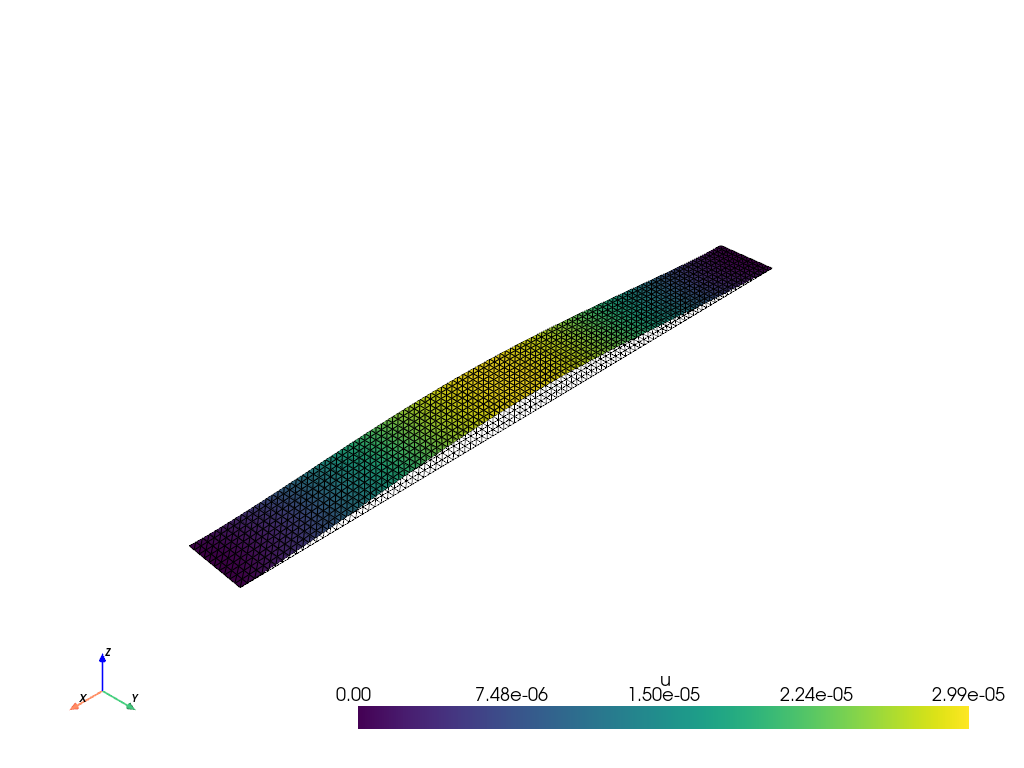

In [17]:
import pyvista
from dolfinx import plot

pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector

u_array_2d = u_sol.x.array.reshape((geometry.shape[0], 2))
u_array_3d = np.hstack((u_array_2d, np.zeros((u_array_2d.shape[0], 1))))
grid["u"] = u_array_3d 

print(grid["u"].ndim)
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=10**4)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")

## External post-processing
For post-processing outside the python code, it is suggested to save the solution to file using either `dolfinx.io.VTXWriter` or `dolfinx.io.XDMFFile` and using [Paraview](https://www.paraview.org/). This is especially suggested for 3D visualization.

In [18]:
from dolfinx import io
from pathlib import Path
results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "linear_elasticity"
with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [u_sol]) as vtx:
    vtx.write(0.0)
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    V_CG1 = fem.functionspace(domain, ("Lagrange", 1, shape))
    # If higher order elements are used, we need to interpolate on Lagrange elements of degree 1
    uh_CG1 = fem.Function(V_CG1)
    uh_CG1.interpolate(u_sol)

    xdmf.write_mesh(domain)
    xdmf.write_function(uh_CG1)

or simply : 

In [19]:
vtk = io.VTKFile(domain.comm, filename.with_suffix(".pvd"), "w")
vtk.write_function(u_sol)

### Changing boundary conditions

If we want to constrain only the vertical component of the displacement field on some boundary, we need to work with the corresponding subspace of the original function space `V`.

In [20]:
# V_uy, mapping = V.sub(1).collapse()
# right_dofs_uy = fem.locate_dofs_geometrical((V.sub(1), V_uy), right)

# uD_y = fem.Function(V_uy)
# bcs2 = [
#     fem.dirichletbc(np.zeros((2,)), left_dofs, V),
#     fem.dirichletbc(uD_y, right_dofs_uy, V.sub(1)),
# ]

# problem = fem.petsc.LinearProblem(
#     a, L, u=u_sol, bcs=bcs2, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
# )
# problem.solve()

# from pathlib import Path
# results_folder = Path("results")
# results_folder.mkdir(exist_ok=True, parents=True)

# vtk = io.VTKFile(domain.comm, results_folder /"linear_elasticity_bc2.pvd", "w")
# vtk.write_function(u_sol)